# Simulating the Harber Bosch process with quantum computing

## Progress

- [x] Hamiltonian `H_1` for all components
- [ ] Reduce number of terms for `H_1`
- [ ] LCU to simulate `H_1`

## Code

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem

### Define Hamiltonian

#### Separate molecules

In [3]:
dataset_N2 = qml.data.load("qchem", molname="N2", bondlength=1.12, basis="STO-3G")
dataset_N2 = dataset_N2[0]

In [4]:
symbols_Fe = ["Fe"]
coordinates_Fe = np.array([0.0, 0.0, 0.0])
# H_Fe, qubits_Fe = qchem.molecular_hamiltonian(symbols_Fe, coordinates_Fe, 
#                                              active_orbitals=14, method='pyscf')
# with setting 14 active orbitals: 23k terms
# without setting: 66k terms
# H_Fe

#### All molecules

In [6]:
Z_H2 = 1*2
Z_N2 = 7*2
Z_Fe = 26
electrons = Z_H2 + Z_N2 + Z_Fe

O_H2 = 1    # 1 active orbitals. 1*2 active e
O_N2 = 5*2  # N: 1s2 2s2 2p3. For N2: 3 active orbitals with 1e. 3*2 active e
O_Fe = 15   # Catalyst. Fe: 1s2 2s2 2p6 3s2 3p6 4s2 3d6. 4 active orbitals with 1e. 4 active electrons
orbitals = O_H2 + O_N2 + O_Fe

active_electrons = 1*2 + 5*2 + 4 
active_orbitals = 1*2 + 3*2 + 4

core, active = qml.qchem.active_space(electrons, orbitals, active_electrons=active_electrons, active_orbitals=active_orbitals)

print(f"Core orbitals: {core}")
print(f"Active orbitals: {active}")

Core orbitals: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Active orbitals: [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


For iron, the outer orbitals are $4s2, 3d6$. They are configured as
- $4s2:\uparrow \downarrow$
- $3d6:\uparrow \downarrow,\uparrow,\uparrow,\uparrow,\uparrow $

Therefore there are four active oribitals

> Defining a chemically meaningful active space depends on the problem and usually requires some experience.
[Source](https://discuss.pennylane.ai/t/co2-active-electrons-orbitals/1589/2)

### Simulate Hamiltonian

In [10]:
symbols = ["Fe", "N", "N", "H", "H"]   # todo 4 more H
coordinates = np.array([0.0, 0.0, 0.0, 
                        0.0, 0.0, 0.2,
                        0.0, 0.0, 0.3,
                        0.0, 0.0, -0.2,
                        0.0, 0.0, -0.3,
                       ])
H, qubits = qchem.molecular_hamiltonian(symbols, coordinates, method='pyscf',
                                        active_electrons=active_electrons,
                                        active_orbitals=len(active))

In [24]:
H.ops[:20]

[I(0),
 Z(0),
 Z(1),
 Z(2),
 Y(2) @ Z(3) @ Y(4),
 X(2) @ Z(3) @ X(4),
 Y(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Y(10),
 X(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ X(10),
 Y(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Z(10) @ Z(11) @ Z(12) @ Z(13) @ Y(14),
 X(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Z(10) @ Z(11) @ Z(12) @ Z(13) @ X(14),
 Y(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Z(10) @ Z(11) @ Z(12) @ Z(13) @ Z(14) @ Z(15) @ Z(16) @ Z(17) @ Y(18),
 X(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Z(10) @ Z(11) @ Z(12) @ Z(13) @ Z(14) @ Z(15) @ Z(16) @ Z(17) @ X(18),
 Z(3),
 Y(3) @ Z(4) @ Y(5),
 X(3) @ Z(4) @ X(5),
 Y(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Z(10) @ Y(11),
 X(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Z(10) @ X(11),
 Y(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Z(10) @ Z(11) @ Z(12) @ Z(13) @ Z(14) @ Y(15),
 X(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Z(10) @ Z(11) @ Z(12) @ Z(13

In [11]:
H

<Hamiltonian: terms=7601, wires=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]>


log_2 of terms, not wires

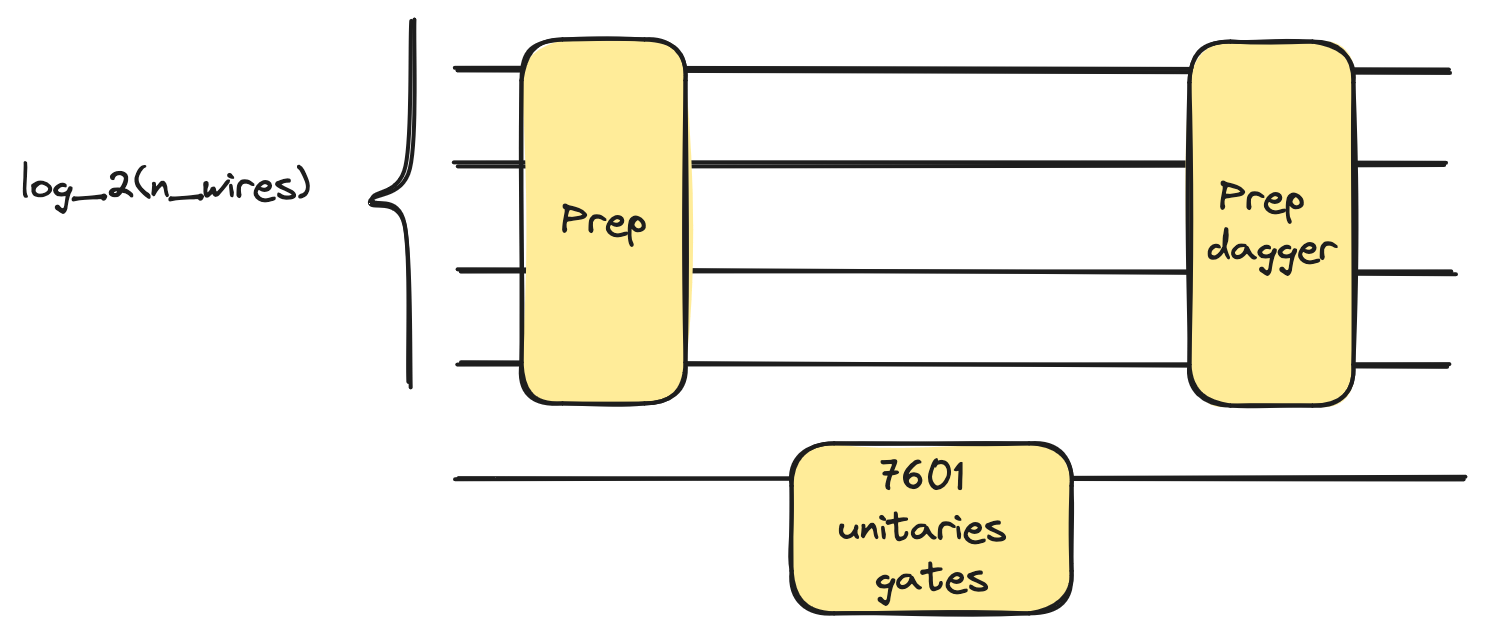

In [23]:
num_wires = len(H.wires)
wires_to_control = int(np.ceil(np.log2(num_wires)))
device = qml.device("lightning.qubit", wires=num_wires + wires_to_control)

## Next step / meeting minute

### 2nd week
The quantity we need to measure
- The intermidiate configurations
    - N2 bonds with Fe -> get the Hamiltonian
    - H2 bond with Fe -> get the Hamiltonian
    - N2 -> 2 N -> get the Hamiltonian
    - H2 -> 2H -> get the Hamiltonian 
    - H+N -> NH3 -> get the Hamiltonian
- Active method https://arxiv.org/pdf/2404.18737 
- https://pubs.acs.org/doi/10.1021/acs.jpca.8b10007
- https://pubs.rsc.org/en/content/getauthorversionpdf/c9cp01611b Reaction pathway

### 1st week
1. Use params `active_electrons`, `active_orbitals` inside `molecular_hamiltonian`
    1. Principled way to do it without knowing Fe is catalyst?
       > valence electron in the outer shell, choose the radius (coordinate?)
    2. Coordinates
       > coordinate for reactant, coordinate for products may be in somewhere else
       > evaluate energy at a lot of different coordinates?
       > Put H2 N2 Fe closer and then farther to see what happens. There must be a method
    3. QPE
       > Time evolution. Trotter, LCU (build different matrix, one of them is time evolution), Qubitizations
2. ZNE?
    1. If it concat a chain of gates, could the real system reach the end of the gates?
    2. Doesn't seem to need more qubit?
3. Paper
   1. https://www.pnas.org/doi/abs/10.1073/pnas.1619152114
   2. https://arxiv.org/pdf/2007.14460